# Moore-Penrose Inverse

In the previous section, we have confirmed the matrix formula $ M = P \cdot C $ which can be stated in natural language that a SEC-SAXS dataset can be expressed as the product of a set of spectral curves and a set of elutional curves. If it was about multiplication, how about division? The answer can be `conceptually` expressed using the Moore-Penrose inverse as follows.

$$ P = M \cdot C^{+} \qquad \qquad (2a) $$
$$ C = P^{+} \cdot M \qquad \qquad (2b) $$

More precisely stated, these equalities are not exact and should be interpreted as follows.

$$ 
\renewcommand{\argmax}{\mathop{\rm argmax}\limits}
\renewcommand{\argmin}{\mathop{\rm argmin}\limits} $$
$$ P = \underset{P}{\operatorname{\argmin}} \| M - P \cdot C \| \qquad \qquad (3a) $$
$$ C = \underset{C}{\operatorname{\argmin}} \| M - P \cdot C \| \qquad \qquad (3b) $$

which means that if $M$ and $C$ (or $P$) are given, we can find $P$ (or $C$) which minimizes the norm.

Confirm the meaning above with scalars, say $M = 12$.

* If $ C = 4$, then $P = M \cdot \frac{1}{4} = 3 $. 
* If $ P = 2$, then $C = \frac{1}{2} \cdot M = 6 $.

Note that, without any contraints, the factorization is arbitrary. For example,

* $12 = 3\cdot4 $
* $12 = 2\cdot6 $
* $12 = 2\sqrt{3} \cdot 2\sqrt{3} $
* or whatever

In other words, be aware that the Moore-Penrose inverse just gives the unique paired reciprocal when the other factor is given, however, the factorization is arbitrary if no counterpart is given.

In this chapter, we will confirm that the Moore-Penrose inverse plays, for matrices, a role analogous to that of the reciprocal for scalars.
 

## Case of Single Component

First, let us take a look at a case where only a single component is involved.

We can observe that the inverse shows a perfect fit to the original for the data without noise. Compare the fit to that for the noisy data. 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from molass.SAXS.Models.Simple import guinier_porod
from molass.SEC.Models.Simple import gaussian

x = np.arange(300)
q = np.linspace(0.005, 0.5, 400)
def plot_single_component_data(scatter_params, elution_params, noise=None):
    G, Rg, d = scatter_params
    h, m, s = elution_params
    fig = plt.figure(figsize=(15,4))
    ax1 = fig.add_subplot(131)
    ax2 = fig.add_subplot(132)
    ax3 = fig.add_subplot(133, projection='3d')

    w, q1 = guinier_porod(q, G, Rg, d, return_also_q1=True)
    # ax1.set_yscale('log')
    ax1.set_title("Scattering Curve: P")
    ax1.plot(q, w)
    ax1.axvline(q1, linestyle=':', color="green", label='Guinier-Porod $Q_1$')
    ax1.legend()

    y = gaussian(x, h, m, s)
    ax2.set_title("Elution Curve: C")
    ax2.plot(x, y)
    
    P = w.reshape((len(q),1))   # make it a matrix
    C = y.reshape((1,len(x)))   # make it a matrix
    M = P @ C                   # matrix multiplication
    if noise is not None:
        M += noise * np.random.randn(*M.shape)
    xx, qq = np.meshgrid(x, q)
    ax3.set_title("3D Data View: M=PC")
    ax3.plot_surface(qq, xx, M)

    Cinv = np.linalg.pinv(C)
    P_ = M @ Cinv
    ax1.plot(q, P_, linestyle=':', color="red", label='P from M')

    fig.tight_layout()

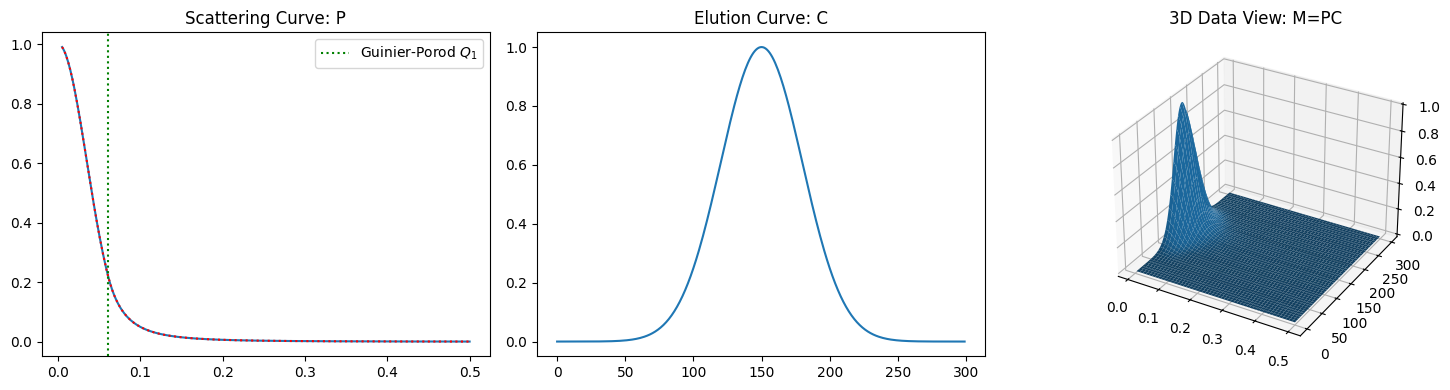

In [3]:
plot_single_component_data((1, 35, 3), (1, 150, 30))

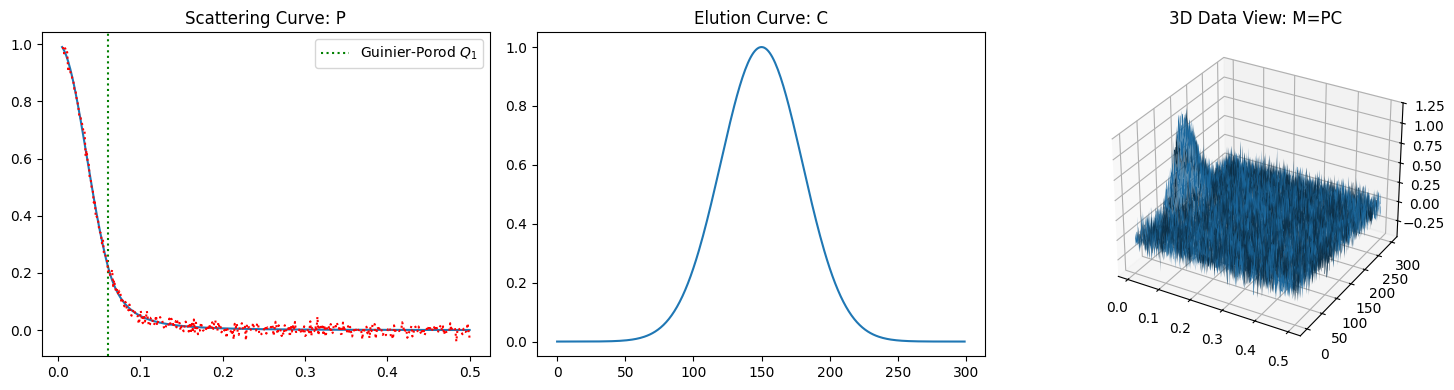

In [4]:
plot_single_component_data((1, 35, 3), (1, 150, 30), noise=0.1)

## Case of Multiple Components

The inverse also works in cases where multiple components are involved, although the effect of noise becomes more pronounced at the same noise level.

In [5]:
def plot_multiple_component_data(scattering_params, elution_params, use_matrices=False, view=None, noise=None):
    fig = plt.figure(figsize=(15,5))
    ax1 = fig.add_subplot(131)
    ax2 = fig.add_subplot(132)
    ax3 = fig.add_subplot(133, projection='3d')
    
    fig.suptitle(r"Illustration of Decomposition $M = P \cdot C$ simulated with Guinier-Prod and EGH Models in Molass Library", fontsize=16)

    # ax1.set_yscale('log')
    ax1.set_title("Scattering Curves in P", fontsize=14)
    ax1.set_xlabel("Q")
    ax1.set_ylabel("Intensity")
    w_list = []
    rgs = []
    for i, (G, Rg, d) in enumerate(scattering_params):
        w, q1 = guinier_porod(q, G, Rg, d, return_also_q1=True)
        w_list.append(w)
        color = "C%d" % i
        ax1.plot(q, w, color=color, label='component-%d: $R_g=%.3g$' % (i+1, Rg))
        rgs.append(Rg)
        # ax1.axvline(q1, linestyle=':', color=color, label='Guinier-Porod $Q_1$')
    ax1.legend()

    y_list = []
    ax2.set_title("Elution Curves in C", fontsize=14)
    ax2.set_xlabel("Frames")
    ax2.set_ylabel("Concentration")
    for i, (h, m, s) in enumerate(elution_params):
        y = gaussian(x, h, m, s)
        y_list.append(y)
        ax2.plot(x, y, label='component-%d: $R_g=%.3g$' % (i+1, rgs[i]))
    ty = np.sum(y_list, axis=0)
    ax2.plot(x, ty, ':', color='red', label='total')
    ax2.legend()

    ax3.set_title(r"$M$ calculated by $P \cdot C$", fontsize=14)
    ax3.set_xlabel("Q")
    ax3.set_ylabel("Frames")
    ax3.set_zlabel("Intensity")
    xx, qq = np.meshgrid(x, q)
    if use_matrices:
        P = np.array(w_list).T
        C = np.array(y_list)
        M = P @ C
    else:
        zz_list = []
        for w, y in zip(w_list, y_list):
            zz =  w.reshape((len(q),1)) @ y.reshape((1,len(x)))
            zz_list.append(zz)
        M = np.sum(zz_list, axis=0)
    if noise is not None:
        M += noise * np.random.randn(*M.shape)
    ax3.plot_surface(qq, xx, M, color='red', alpha=0.5)
    # ax3.legend()
    if view is not None:
        ax3.view_init(azim=view[0], elev=view[1])
    Cinv = np.linalg.pinv(C)
    P_ = M @ Cinv
    for py in P_.T:
        ax1.plot(q, py, linestyle=':', color="red")
    fig.tight_layout()
    fig.subplots_adjust(right=0.95)

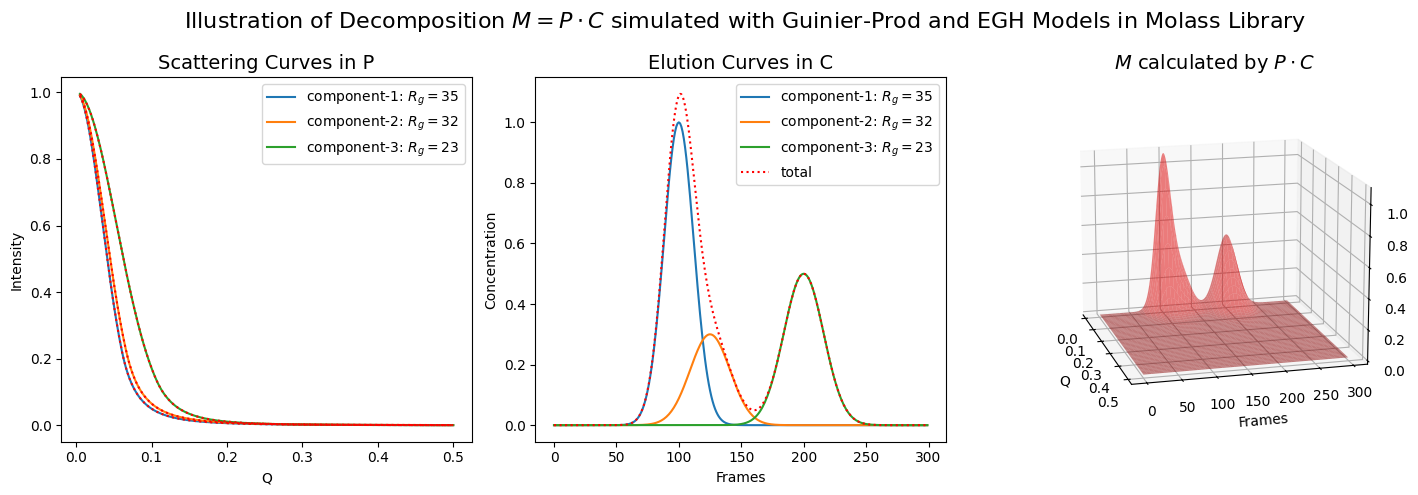

In [6]:
rgs = (35, 32, 23)
scattering_params = [(1, rgs[0], 3), (1, rgs[1], 3), (1, rgs[2], 4)]
elution_params = [(1, 100, 12), (0.3, 125, 16), (0.5, 200, 16)]
plot_multiple_component_data(scattering_params, elution_params, use_matrices=True, view=(-15, 15))

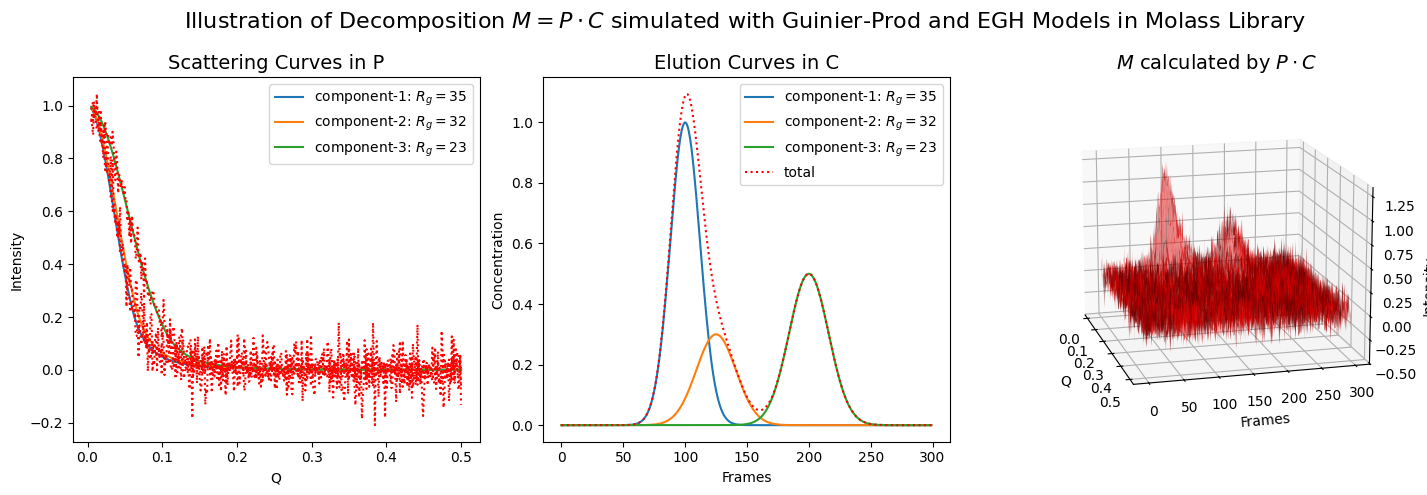

In [7]:
plot_multiple_component_data(scattering_params, elution_params, use_matrices=True, view=(-15, 15), noise=0.1)